In [22]:
import pickle
from sklearn.datasets import load_svmlight_file, load_svmlight_files
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn import svm
import numpy
import pandas as pd
import jsonlines
from matplotlib_venn import  venn2, venn2_circles, venn2_unweighted,  venn3, venn3_unweighted, venn3_circles
import scipy
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import timeit  # calcular metrica de tempo
import sys


ini = timeit.default_timer()
SEED = 42
#dataset = "aisopos_ntua_2L"
dataset = "yelp_review_2L"
index_fold = 0

#dataset = [sys.argv[1]]
#index_fold = [int(sys.argv[2])]

In [2]:
def classifica(x_train, y_train, x_test):
    estimator = svm.LinearSVC(C=1, random_state=SEED, max_iter=1000)
    #estimator = LogisticRegression(solver='liblinear')
    estimator.fit(x_train,y_train)
    return estimator.predict(x_test)    

def arredonda(number, precisao=1):
    """ Arredonda number in precision. Example: arredonda(2.1234, 2); Return='2.12'"""
    return float(f'%.{precisao}f'%(number))

In [23]:
path = "../combinacao_atencao/"
ids = pickle.load( open(f'{path}dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
if dataset == 'sst2':
    x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test = load_svmlight_files([open(f'{path}kaggle_tfidf/{dataset}_train{index_fold}', 'rb'), open(f'{path}kaggle_tfidf/{dataset}_val{index_fold}', 'rb'), open(f'{path}kaggle_tfidf/{dataset}_test{index_fold}', 'rb')])
else:
    x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test = load_svmlight_files([open(f'{path}kaggle_tfidf/{dataset}_tfidf_train{index_fold}', 'rb'), open(f'{path}kaggle_tfidf/{dataset}_tfidf_val{index_fold}', 'rb'), open(f'{path}kaggle_tfidf/{dataset}_tfidf_test{index_fold}', 'rb')])

#estimator = RandomForestClassifier(random_state=SEED)
#estimator = LogisticRegression(solver='liblinear')

#estimator = GridSearchCV(estimator, [{'C':  [0.01, 0.1, 1, 10]}], cv=5, scoring='f1_macro', n_jobs=-1)
#estimator = NearestCentroid()

#y_pred_tfidf = classifica(x_train_tfidf, y_train, x_test_tfidf)

path = "../fasttext/"
nome_experimento= f'{path}{dataset}_fasttext' 
webkb = jsonlines.open(f'{nome_experimento}.json')
docs = []
for line in webkb:
    docs.append( (line['id'], line['fasttext'], line['label']) )    
    
X = pd.DataFrame(docs, columns=['id', 'fasttext', 'label'])
x_train = X.query(f"id == {ids['train_idxs'][index_fold]}")
x_val = X.query(f"id == {ids['val_idxs'][index_fold]}")
x_test = X.query(f"id == {ids['test_idxs'][index_fold]}")


#y_pred_fasttext = classifica(list(x_train['fasttext']), y_train, list(x_test['fasttext']))

x_train_tfidf_fasttext = hstack([ x_train_tfidf, scipy.sparse.csr_matrix( list(x_train['fasttext']) ) ])
x_test_tfidf_fasttext = hstack([ x_test_tfidf, scipy.sparse.csr_matrix( list(x_test['fasttext'])  ) ])

#y_pred_tfidf_fasttext = classifica(x_train_tfidf_fasttext, y_train, x_test_tfidf_fasttext)

# escreve =  jsonlines.open(f'pred/{dataset}{index_fold}.json', 'w')

# doc = {'index_fold' : index_fold, 'y_pred_tfidf' : list(y_pred_tfidf), 'Macro-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf, average='macro'),
#                        'Micro-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf, average='micro'),
#                        'Weighted-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf, average='weighted'),
#                        'time' : timeit.default_timer() - ini
#                       }
# escreve.write(doc)
# doc = {'index_fold' : index_fold, 'y_pred_fasttext' : list(y_pred_fasttext), 'Macro-f1' : sklearn.metrics.f1_score( y_test , y_pred_fasttext, average='macro'),
#                        'Micro-f1' : sklearn.metrics.f1_score( y_test , y_pred_fasttext, average='micro'),
#                        'Weighted-f1' : sklearn.metrics.f1_score( y_test , y_pred_fasttext, average='weighted'),
#                        'time' : timeit.default_timer() - ini
#                       }
# escreve.write(doc)
# doc = {'index_fold' : index_fold, 'y_pred_tfidf_fasttext' : list(y_pred_tfidf_fasttext), 'Macro-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf_fasttext, average='macro'),
#                        'Micro-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf_fasttext, average='micro'),
#                        'Weighted-f1' : sklearn.metrics.f1_score( y_test , y_pred_tfidf_fasttext, average='weighted'),
#                        'time' : timeit.default_timer() - ini
#                       }
# escreve.write(doc)

#print(f"Macro-f1: { sklearn.metrics.f1_score( y_test, y_pred, average='macro')}" )
#print(f"Micro-f1: { sklearn.metrics.f1_score( y_test, y_pred, average='micro')}" )
#macro_lista.append(sklearn.metrics.f1_score( y_test, y_pred, average='macro'))

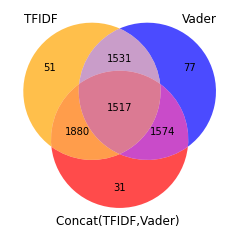

In [34]:
acertos_tfidf = y_test == y_pred_tfidf
acertos_tfidf = set( numpy.where(acertos_tfidf == True)[0] )
acertos_fasttext = y_test == y_pred_fasttext
acertos_fasttext = set( numpy.where(acertos_fasttext == True)[0] )
acertos_tfidf_fasttext = y_test == y_pred_tfidf_fasttext
acertos_tfidf_fasttext = set( numpy.where(acertos_tfidf_fasttext == True)[0] )

#print(f'acertos_tfidf:          {acertos_tfidf}')
#print(f'acertos_fasttext:       {acertos_fasttext}')
#print(f'acertos_tfidf_fasttext: {acertos_tfidf_fasttext}')

A = acertos_tfidf; B = acertos_fasttext; C = acertos_tfidf_fasttext
apenas_A = A.difference(B, C) 
apenas_B = B.difference(A, C) 
apenas_C = C.difference(A, B) 



osDois = A.intersection(B) 

nenhum = len(y_test) - len(A.union(B,C))

#print(len(apenas_A))


#venn2(subsets = (len(acertos_tfidf), len(acertos_fasttext), len(acertos_tfidf_fasttext)), set_labels = (f'TFIDF\n\n Nenhum Acertou: {nenhum}  ({arredonda(nenhum/len(y_test)*100)}%)', 'Vader'), set_colors=("orange", "blue"),alpha=0.7)
#print(f'No hits: {nenhum} ({arredonda(nenhum/len(y_test)*100)}%)')

#venn2(subsets = (10, 0, 0), set_labels = ('TFIDF', 'Vader'), set_colors=("orange", "blue"),alpha=0.7)



# A B AB C AC CB ABC
venn3_unweighted(subsets=(len(apenas_A), len(apenas_B), len( A.intersection(B)),
 len(apenas_C), len(A.intersection(C)) , len(C.intersection(B)) , len(A.intersection(B,C) )), 
      set_labels=(f'TFIDF', 'Vader', f'Concat(TFIDF,Vader) '), 
      set_colors=("orange", "blue", "red"), alpha=0.7)
# \n\n Dataset: {dataset}\n Total: TFIDF: {len(A)}, Vader: {len(B)}, Concat: {len(C)}\n Nenhum Acertou: {nenhum}  ({arredonda(nenhum/len(y_test)*100)}%)

plt.savefig(f'fig/{dataset}.jpg', format='jpg', dpi=100) 


In [35]:
from sklearn.metrics import silhouette_score

#silhouette_score(list(x_test['bert']), list(x_test['label']))

doc = {'tfidf_silhouette': silhouette_score(x_test_tfidf, y_test),  
'fasttext_silhouette': silhouette_score(list(x_test['fasttext']), y_test),  
'tfidf_fasttext_silhouette': silhouette_score(x_test_tfidf_fasttext, y_test) }  

print(doc)

{'tfidf_silhouette': -4.551488578386957e-05, 'fasttext_silhouette': -0.02865798752536418, 'tfidf_fasttext_silhouette': -0.01584913005506909}


/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


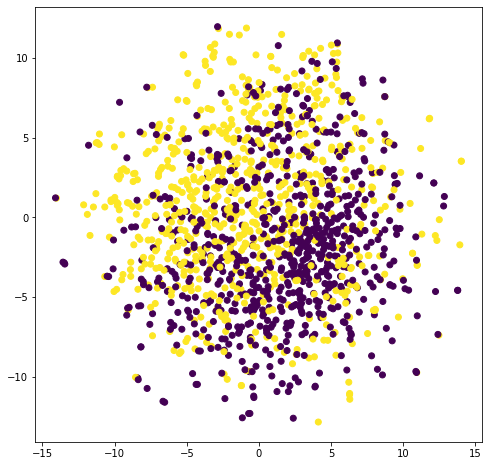

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_test_tfidf)
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y_test )
plt.savefig(f'fig/tsne_tfidf_{dataset}.jpg', format='jpg', dpi=100) 

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(list(x_test['fasttext']))
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y_test )
plt.savefig(f'fig/tsne_fasttext_{dataset}.jpg', format='jpg', dpi=100) 

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_test_tfidf_fasttext)
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y_test )
plt.savefig(f'fig/tsne_tfidf_fasttext_{dataset}.jpg', format='jpg', dpi=100) 




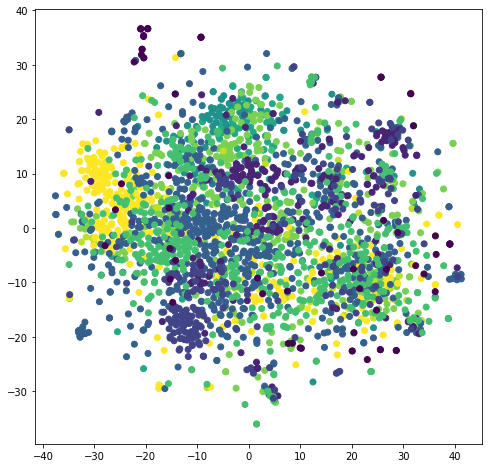

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(list(x_test['fasttext']))

plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y_test )